In [13]:
import os
import sys
sys.path.append("/home/ubuntu/Desktop/SuperPoint-VO/")

In [151]:
import numpy as np
import cv2

from sp_extractor import SuperPointFrontend, PointTracker
from norm_visual_odometry import PinholeCamera, VisualOdometry

import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [9]:
class SP_VisualOdometry:
    def __init__(self, cam):
        self.frame_stage = 0
        self.cam = cam
        self.new_frame = None
        self.last_frame = None
        self.cur_R = None
        self.cur_t = None
        self.px_ref = None
        self.px_cur = None
        self.focal = cam.fx
        self.pp = (cam.cx, cam.cy)
        self.trueX, self.trueY, self.trueZ = 0, 0, 0
        self.detector = SuperPointFrontend(weights_path="/home/ubuntu/Desktop/SuperPoint-VO/weights/superpoint_v1.pth",
                                           nms_dist=4,
                                           conf_thresh=0.015,
                                           nn_thresh=0.7,
                                           cuda=True)
        self.tracker = PointTracker(max_length=2, nn_thresh=self.detector.nn_thresh)

    def featureTracking(self, new_frame):
        pts, desc, heatmap = self.detector.run(new_frame)
        # Add points and descriptors to the tracker.
        self.tracker.update(pts, desc)
        # Get tracks for points which were match successfully across all frames.
        tracks = self.tracker.get_tracks(min_length=1)
        # Normalize track scores to [0,1].
        tracks[:, 1] /= float(self.detector.nn_thresh)
        kp1, kp2 = self.tracker.draw_tracks(tracks)
        return kp1, kp2

In [10]:
cam_param = PinholeCamera(2048, 1536, 1725.842032333, 1725.842032333, 1024.0, 768.0)

In [14]:
sp_vo = SP_VisualOdometry(cam_param)

In [112]:
querty_img_file = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394887779869.jpg'
pred_img_file = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394608779869.jpg'

In [113]:
query_img = cv2.imread(querty_img_file)
pred_img = cv2.imread(pred_img_file)

In [175]:
sp_vo.featureTracking(query_img)
px_ref, px_cur = sp_vo.featureTracking(pred_img)
curr_size = px_ref.shape[0]

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


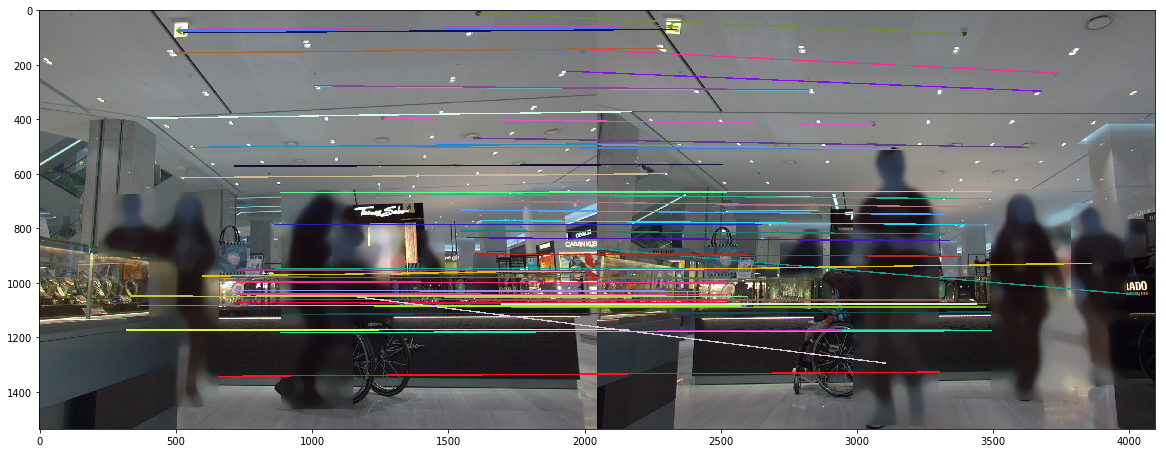

In [189]:
corr_img = np.hstack([query_img, pred_img])
for corr_idx in range(curr_size):
    if (corr_idx % 10 == 0):
        corr_img = cv2.line(corr_img, 
                            (px_ref[corr_idx][0],px_ref[corr_idx][1]), 
                            (pred_img.shape[1]+px_cur[corr_idx][0], px_cur[corr_idx][1]), 
                            (np.random.randint(255),np.random.randint(255),np.random.randint(255)), 3)
plt.imshow(corr_img)